Getting Data

In [1]:
"""
Computes correlations for the cleaned data.
"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import openpyxl

from data_cleaning import get_cleaned_data


# from data_labels import get_desc_table

df = get_cleaned_data()

C:\Users\xabbo\AppData\Local\Temp/ipykernel_14160/1092870935.py:15: DtypeWarning: Columns (30,157,383,384,393,480,724,725,762) have mixed types.Specify dtype option on import or set low_memory=False.
  df = get_cleaned_data()


In [2]:
# eliminating diagonal values
corr_values = df.corr()
np.fill_diagonal(corr_values.values, 0)

Pre Processing

In [3]:
# Scan each row to see if it has any correlations over 0.5 or under -0.5. If not, add to list to delete
for column in corr_values:
    corr_values[column].mask(corr_values[column] >= 1.0, np.nan, inplace=True)
    corr_values[column].mask(corr_values[column] <= -1.0, np.nan, inplace=True)
        

rows_delete = []
for index, row in corr_values.iterrows():
    delete = True
    for value in row: 
        if (value >= 0.75 and value < 1.0) or (value <= -0.75 and value > -1.0):
            delete = False
    rows_delete.append(tuple([index, delete]))

In [4]:
# Now, delete row/columns that we've identified as True
# Initial size = 735x735, reduced is 644x644

for row in rows_delete:
    if row[1]:
        corr_values = corr_values.iloc[corr_values.index!=row[0], corr_values.columns!=row[0]]

corr_values.shape

(559, 559)

Top Correlations:

In [5]:
# following two functions identify top correlation pairs

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# isolating top 50 pairs to optimize feature visibility
top = get_top_abs_correlations(corr_values, 25)

In [6]:
# recording all rows + columns of interest

topdf = top.unstack(level=-1)
features = set(list(topdf.columns) + topdf.axes[0].tolist())
len(features)

35

In [7]:
# filtering out nonimportant features

for col in corr_values.columns:
    if col not in features or col == "PATID":
        corr_values = corr_values.iloc[corr_values.index != col, corr_values.columns != col]

corr_values.shape

(35, 35)

Text(0.5, 1.0, 'Correlation Matrix')

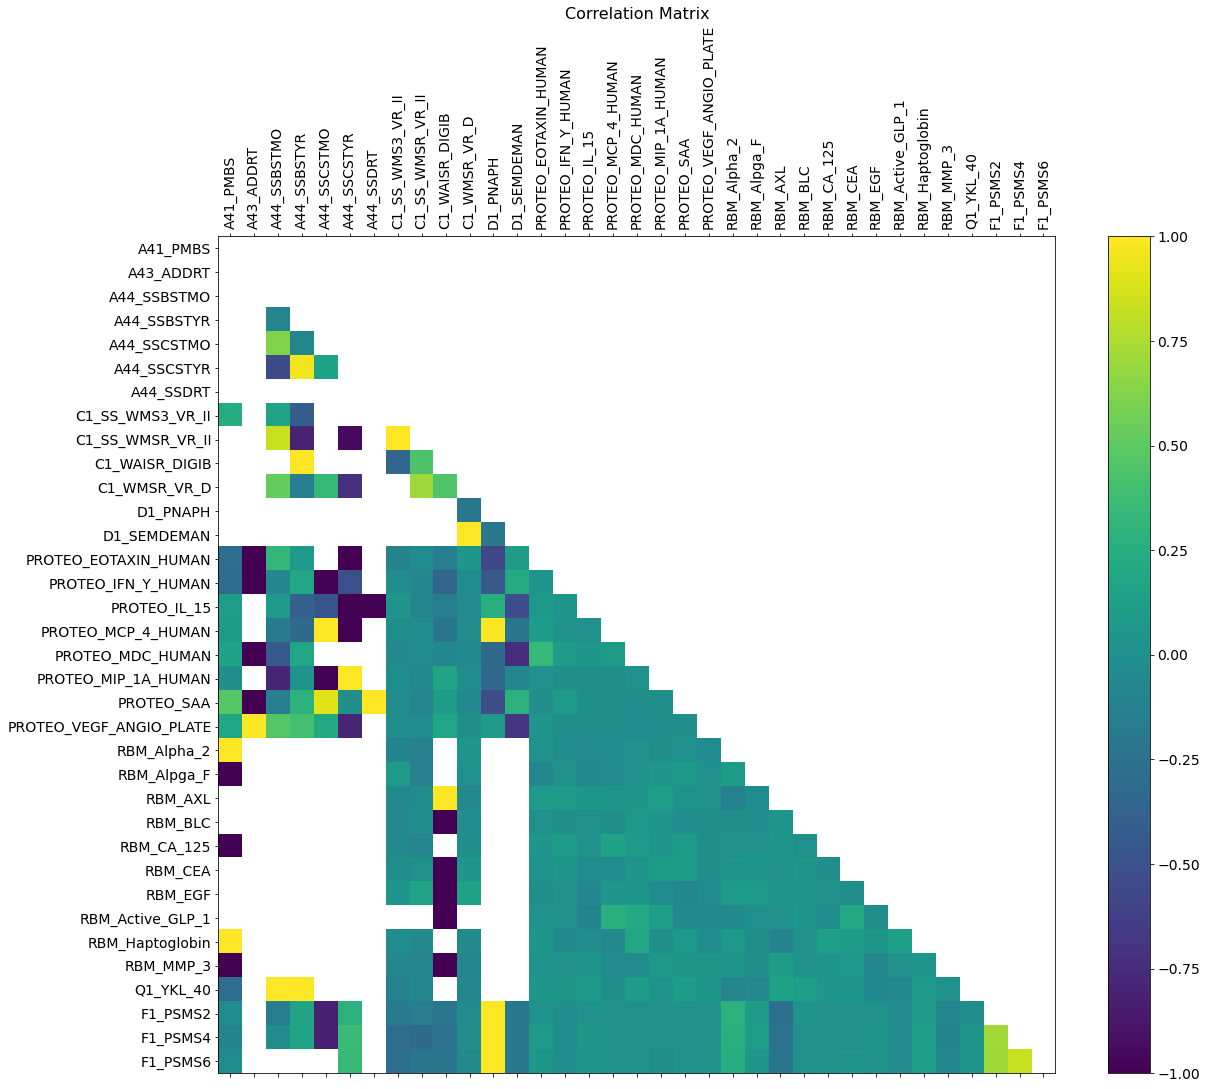

In [8]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_values, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_values[mask] = np.nan
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_values, fignum=f.number)
plt.xticks(range(corr_values.select_dtypes(['number']).shape[1]), corr_values.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corr_values.select_dtypes(['number']).shape[1]), corr_values.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [9]:
codebook = pd.read_excel("20220602-TARCC-Codebook.xlsx")

codebook["Variable Name"] = codebook["Variable Name"].astype(str)

codebook["Variable Name"] = codebook["Variable Name"].apply(str.upper)

val = codebook[codebook["Variable Name"] == str('A41_PMBS')]["Description"].values


In [10]:
def get_desc_table(cols):
    descs = []
    for col in cols:
        entry = {}
        col = str(col).upper()
        row = codebook[codebook["Variable Name"] == col]
        entry["Variable Name"] = col
        entry["Description"] = row["Description"].values
        descs.append(entry)
    for entry in descs:
        if len(entry["Description"]) != 0:
            entry["Description"] = entry["Description"][0]
        else:
            entry["Description"] = "Incompatible"
    return descs

dictionary = get_desc_table(list(corr_values.columns))

In [11]:
print(len(dictionary), dictionary)

35 [{'Variable Name': 'A41_PMBS', 'Description': 'Prescription B: Strength'}, {'Variable Name': 'A43_ADDRT', 'Description': 'Anti-dementia Drug Hx D: Route'}, {'Variable Name': 'A44_SSBSTMO', 'Description': 'Systemic Steroids Hx B: Start date (month)'}, {'Variable Name': 'A44_SSBSTYR', 'Description': 'Systemic Steroids Hx B: Start date (year)'}, {'Variable Name': 'A44_SSCSTMO', 'Description': 'Systemic Steroids Hx C: Start date (month)'}, {'Variable Name': 'A44_SSCSTYR', 'Description': 'Systemic Steroids Hx C: Start date (year)'}, {'Variable Name': 'A44_SSDRT', 'Description': 'Systemic Steroids Hx D: Route'}, {'Variable Name': 'C1_SS_WMS3_VR_II', 'Description': 'Scaled Score WMS-3 Visual Reproduction 2'}, {'Variable Name': 'C1_SS_WMSR_VR_II', 'Description': 'Scaled Score WMS-R Visual Reproduction 2'}, {'Variable Name': 'C1_WAISR_DIGIB', 'Description': 'WAIS-R Digit Span Backward'}, {'Variable Name': 'C1_WMSR_VR_D', 'Description': 'WMS-R VR 1 Figure D'}, {'Variable Name': 'D1_PNAPH', 'D

In [12]:
data_names = pd.DataFrame(data=dictionary)
data_names.to_excel("data_names.xlsx", index=False)